Shape: (6607, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              66

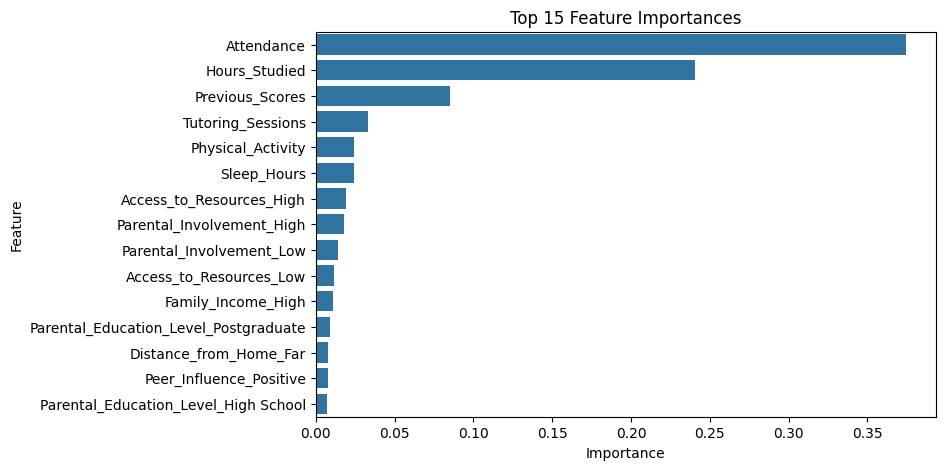

/tmp/ipython-input-569096035.py:244: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)


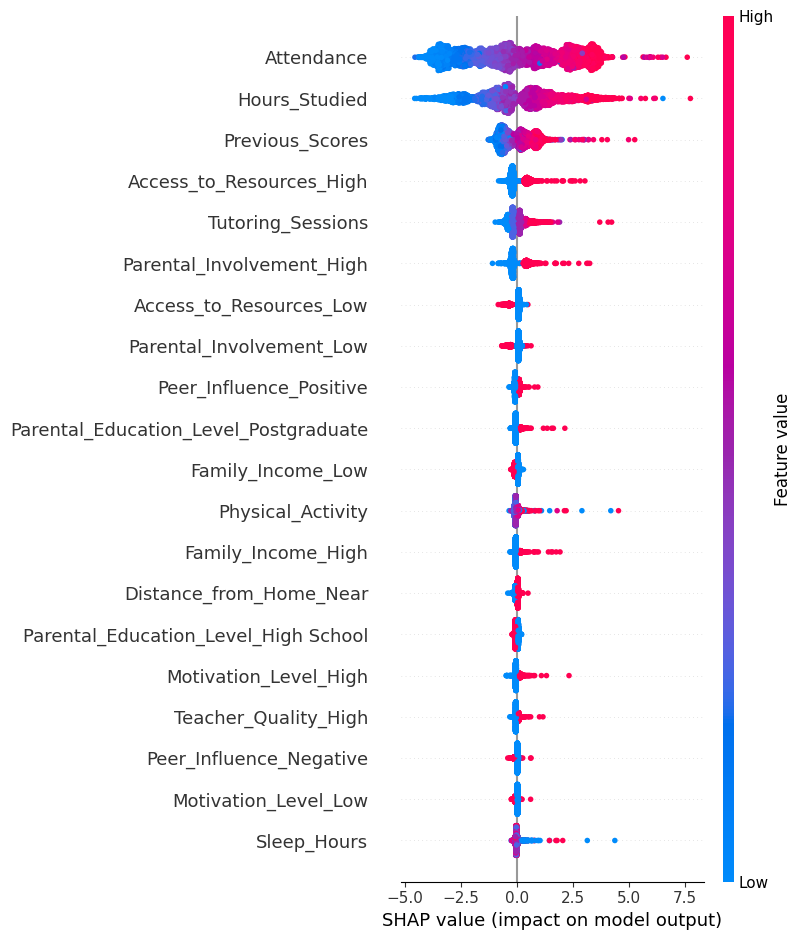

/tmp/ipython-input-569096035.py:255: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fairness = test_with_preds.groupby('Gender').apply(


In [3]:
# ============================================================
# MSc IT – Business Data Analytics Project
# Student  – End-to-End Notebook
# Author: Vivek Patel
# Target: Exam_Score (Regression)
# ============================================================

# =========================
# 0. ENVIRONMENT SETUP
# =========================

# Required Python version: 3.9+
# Install once (if needed):
# !pip install numpy pandas matplotlib seaborn scikit-learn shap xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import shap

np.random.seed(42)

# =========================
# 1. DATA LOADING
# =========================

# File required in same directory:
# StudentPerformanceFactors.csv

data = pd.read_csv('StudentPerformanceFactors (1).csv')

print('Shape:', data.shape)
data.head()

# =========================
# 2. INITIAL DATA CHECKS
# =========================

data.info()

data.describe(include='all').T

# Missing values check
missing = data.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

# =========================
# 3. TARGET & FEATURE SEPARATION
# =========================

target = 'Exam_Score'
X = data.drop(columns=[target])
y = data[target]

# =========================
# 4. TRAIN / TEST SPLIT
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 5. FEATURE TYPE IDENTIFICATION
# =========================

numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

print('Numerical:', numerical_features.tolist())
print('Categorical:', categorical_features.tolist())

# =========================
# 6. PREPROCESSING PIPELINES
# =========================

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# =========================
# 7. BASELINE MODEL (MEAN PREDICTOR)
# =========================

baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

baseline_results = {
    'Model': 'Baseline (Mean)',
    'MAE': baseline_mae,
    'RMSE': baseline_rmse,
    'R2': baseline_r2
}

baseline_results

# =========================
# 8. MODEL PIPELINES
# =========================

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_test, preds),
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'R2': r2_score(y_test, preds)
    })

results_df = pd.DataFrame([baseline_results] + results)
results_df

# =========================
# 9. CROSS-VALIDATION (5-FOLD)
# =========================

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    cv_results[name] = -scores.mean()

pd.Series(cv_results, name='CV_MAE')

# =========================
# 10. HYPERPARAMETER TUNING (RANDOM FOREST)
# =========================

rf_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20]
}

grid = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_

rf_preds = best_rf.predict(X_test)

rf_tuned_results = {
    'Model': 'Random Forest (Tuned)',
    'MAE': mean_absolute_error(y_test, rf_preds),
    'RMSE': np.sqrt(mean_squared_error(y_test, rf_preds)),
    'R2': r2_score(y_test, rf_preds)
}

rf_tuned_results

# =========================
# 11. FEATURE IMPORTANCE (TREE-BASED)
# =========================

feature_names = (
    numerical_features.tolist() +
    list(best_rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_features))
)

importances = best_rf.named_steps['model'].feature_importances_

fi = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi = fi.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=fi)
plt.title('Top 15 Feature Importances')
plt.show()

# =========================
# 12. SHAP INTERPRETABILITY
# =========================

X_train_transformed = best_rf.named_steps['preprocess'].transform(X_train)

explainer = shap.TreeExplainer(best_rf.named_steps['model'])
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

# =========================
# 13. ETHICS & FAIRNESS CHECK (EXAMPLE: GENDER)
# =========================

if 'Gender' in X_test.columns:
    test_with_preds = X_test.copy()
    test_with_preds['Actual'] = y_test.values
    test_with_preds['Predicted'] = best_rf.predict(X_test)

    fairness = test_with_preds.groupby('Gender').apply(
        lambda df: mean_absolute_error(df['Actual'], df['Predicted'])
    )
    fairness

# =========================
# 14. FINAL RESULTS TABLE
# =========================

final_results = pd.DataFrame(
    [baseline_results] + results + [rf_tuned_results]
)

final_results

# =========================
# 15. SAVE OUTPUTS
# =========================

final_results.to_csv('model_results.csv', index=False)

# =========================
# END OF NOTEBOOK
# =========================

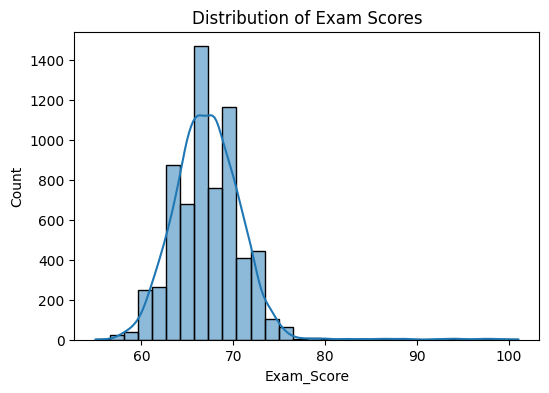

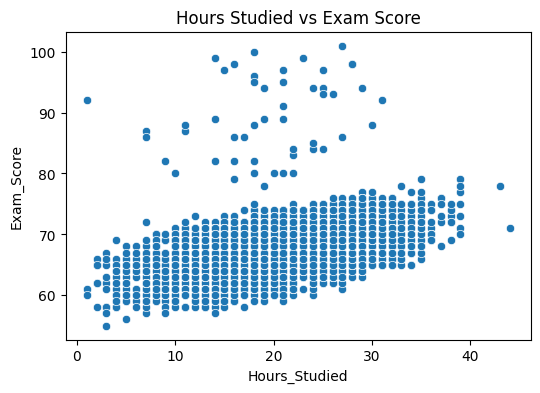

In [4]:
# =========================
# EDA VISUALIZATIONS
# =========================

plt.figure(figsize=(6,4))
sns.histplot(data['Exam_Score'], bins=30, kde=True)
plt.title('Distribution of Exam Scores')
plt.show()

# Relationship with Hours Studied (if exists)
if 'Hours_Studied' in data.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='Hours_Studied', y='Exam_Score', data=data)
    plt.title('Hours Studied vs Exam Score')
    plt.show()


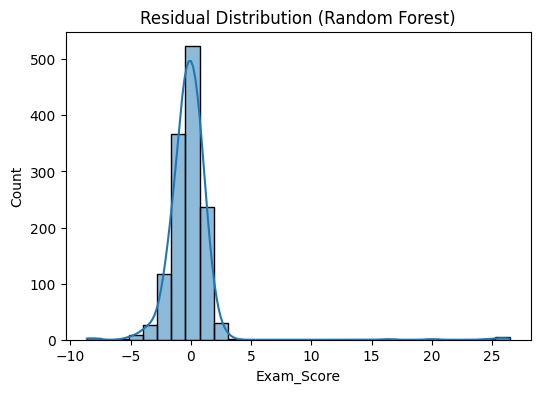

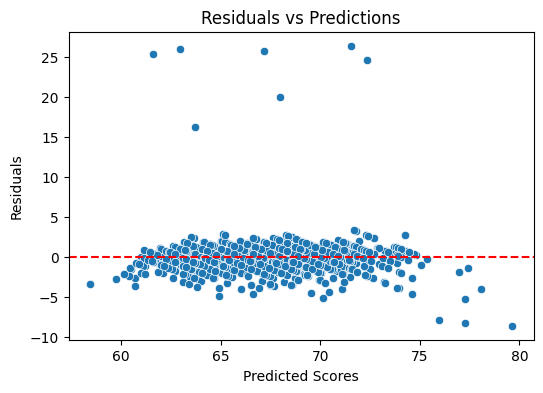

In [5]:
# =========================
# RESIDUAL ANALYSIS
# =========================

residuals = y_test - rf_preds

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residual Distribution (Random Forest)')
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=rf_preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.show()


In [6]:
import joblib

joblib.dump(best_rf, 'best_model.pkl')


['best_model.pkl']